<a href="https://colab.research.google.com/github/ba88052/Earnings_Call_Transcripts_Analyze/blob/main/Earnings_Call_Transcripts_Analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment prepare


In [ ]:
!pip3 install beautifulsoup4
!pip3 install selenium==4.1.5
!pip3 install webdriver-manager
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

#查看是否在colab環境
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

from google.colab import drive

#import常用套件與版本
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
import gdown
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import sys
import os


#掛載Google Drive（需更改路徑）
# if in_colab:
#   home_dir = ""
#   drive.mount("/content/drive")
#   groot_dir = "/content/drive/My Drive/DataAnalysis"

# import os
# file1 = os.path.join(groot_dir, "Testing.jpg")
# f = file1
# print(f)
# print(os.path.exists(f))

#將印出圖片時需要的設定函數化
def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax


#偵測環境
import platform
print("We're running on", platform.platform())
print("Python version", platform.python_version())
print(platform.uname())


#印出當前時間（確認時間沒問題）
from datetime import datetime
from dateutil.relativedelta import *
local_time = lambda x, offset: x + relativedelta(hours= offset)
#因為用虛擬機，內置為格林威治+0時間
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

    import gdown, requests

#從googledrive抓
def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

#用requests 從網址url抓
def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath

print('helpers imported')
print_now()


# print('\nData storage points to ==>', groot_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 979 kB 31.9 MB/s 
     |████████████████████████████████| 140 kB 105.4 MB/s 
     |████████████████████████████████| 384 kB 75.4 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 78.0 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Looki

#Get Earnings Call Data

In [ ]:
key = "MU"
dir = f'earning-call/{key}'
if not os.path.isdir(dir):
    os.makedirs(dir)

url = "https://statementdog.com/users/sign_in"
payload = {'email': 'ba880502@gmail.com', 'password': 'qwertyuiop'}
headers = {'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
options = webdriver.ChromeOptions()
options.add_argument("--disable-notifications")
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('chromedriver',chrome_options=options)
driver.get(url)
time.sleep(1)
driver.find_element_by_id("user_email").send_keys("ba880502@gmail.com")
time.sleep(1)
driver.find_element_by_id("user_password").send_keys("qwertyuiop")
time.sleep(1)
driver.find_element_by_class_name("submit-btn").click()
time.sleep(2)
driver.find_element_by_name("stockid").send_keys(key)
time.sleep(1)
driver.find_element_by_class_name("search-form-button").click()
time.sleep(2)
driver.find_element_by_class_name("menu-item-statement").click()
time.sleep(1)
driver.find_element_by_xpath("//*[text()='電子書']").click()
time.sleep(1)

soup = BeautifulSoup(driver.page_source, "html.parser")
links = soup.find_all("a")

test = []

for link in links:
    if re.search('逐字稿', link.text) != None:
        driver.find_element_by_xpath(f'//a[@href="{link["href"]}"]' ).click()
        time.sleep(1)
        driver.switch_to.window(driver.window_handles[1])
        time.sleep(1)

        title = driver.find_element_by_class_name("earnings-calls-header-title")
        fileNameArr = str(BeautifulSoup(title.text, "html.parser"))
        fileName = key + fileNameArr[10:14] + "_" + "Q" + fileNameArr[-8]
        # print(fileName)

        containers = driver.find_element_by_class_name("translate-content-container")
        ps = BeautifulSoup(containers.text, "html.parser")

        with open(f'./earning-call/{key}/{fileName}.txt', 'w', encoding='UTF-8') as f:            
            for p in ps:
                f.write(p + "\n")
                
                # print(p.text)
        
        driver.close()
        time.sleep(1)
        driver.switch_to.window(driver.window_handles[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: find_element_by_name is deprecated. Please use find_element(by=By.NAME, value=name) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instea

In [ ]:
# #刪除檔案夾
# import shutil
# shutil.rmtree("earning-call")

#Clean Data

In [ ]:
!wget https://github.com/odek53r/Data-Science-Camp/raw/main/SourceHanSerifK-Light.otf
import string
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_data(txt_file_path):
    nltk_stopwords = nltk.corpus.stopwords.words("english")
    for w in ['!',',','.','?','-s','-ly','</s>','s', '-']:
        nltk_stopwords.append(w)
        
    lemmatizer = WordNetLemmatizer()

    onegrams = []
    twograms = []
    threegrams = []
    
    with open(txt_file_path, "r")as fn:
        lines = fn.readlines()
        lines = list(map(lambda x: x.strip(),lines))
    for line in lines:
        if len(line) != 0:
            two = ngrams(line.split(), 2)
            for i in two:
                strs = ' '.join(i)
                twograms.append(strs.lower())
                
            three = ngrams(line.split(), 3)
            for i in three:
                strs = ' '.join(i)
                threegrams.append(strs.lower())

            x = lambda x: WhitespaceTokenizer().tokenize(x)
            ones = x(line)
            for one in ones:
                if one not in nltk_stopwords and one not in string.punctuation:
                    onegrams.append(lemmatizer.lemmatize(one.lower()))
            
            
    return onegrams, twograms, threegrams

def count_num(datas):
    count = {}
    for word in datas:
        if word in count and len(word) >1 :
            count[word] = count[word]+1
        else:
            count[word] = 1
    return count

def make_wordcloud_dict(dic):
    import wordcloud
    from wordcloud import WordCloud
    import matplotlib
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(
            background_color = 'black',
            font_path = './SourceHanSerifK-Light.otf', # 放入中文字型檔路徑
            colormap="tab20c",
            width = 1600,
            height = 800,
            margin = 2)
    # wordcloud 套件 Input 需放入詞頻統計的 dict 型態變數
    wordcloud = wordcloud.generate_from_frequencies(dic) 
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

--2022-10-03 14:13:41--  https://github.com/odek53r/Data-Science-Camp/raw/main/SourceHanSerifK-Light.otf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/odek53r/Data-Science-Camp/main/SourceHanSerifK-Light.otf [following]
--2022-10-03 14:13:41--  https://raw.githubusercontent.com/odek53r/Data-Science-Camp/main/SourceHanSerifK-Light.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23420516 (22M) [application/octet-stream]
Saving to: ‘SourceHanSerifK-Light.otf.1’

SourceHanSerifK-Lig 100%[===================>]  22.33M  --.-KB/s    in 0.06s   

2022-10-03 14:13:41 (400 MB/s) - ‘SourceHanSerifK-L

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
columns = ["title","year", "quarter", "text", "Server_count", "PC_count"]
EC_df = pd.DataFrame(columns = columns)
num = 0
for filename in os.listdir(f"earning-call/{key}"):
    EC_df.loc[num, "text"] = clean_data(f"./earning-call/{key}/{filename}")
    count = count_num(clean_data(f"./earning-call/{key}/{filename}")[0])
    try:
        server = count["server"] 
    except:
        server = 0
    try:
        PC = count["pc"]
    except:
        PC = 0
    EC_df.loc[num, "title"] = filename[2:-4]
    EC_df.loc[num, "quarter"] = filename[-5]
    EC_df.loc[num, "year"] = int(filename[2:6])
    EC_df.loc[num, "Server_count"] =  server 
    EC_df.loc[num, "PC_count"] = PC
    EC_df = EC_df.sort_values(by = "title")
    EC_df.reset_index(inplace = True, drop = True)
    num += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [ ]:
EC_df

,title,year,quarter,text,Server_count,PC_count
0,2002_Q1,2002,1,"([editor, operator, good, afternoon,, lady, ge...",0,5
1,2002_Q2,2002,2,"([operator, good, afternoon, lady, gentlemen.,...",9,0
2,2002_Q3,2002,3,"([operator, good, evening,, lady, i, said, lik...",0,1
3,2004_Q1,2004,1,"([operator, good, afternoon,, lady, gentleman,...",0,8
4,2004_Q2,2004,2,"([operator, good, afternoon,, lady, gentlemen....",0,0
...,...,...,...,...,...,...
72,2021_Q4,2021,4,"([operator, good, afternoon., my, name, latif,...",7,31
73,2022_Q1,2022,1,"([operator, hello., thank, standing, by,, welc...",8,22
74,2022_Q2,2022,2,"([operator, thank, standing, by,, welcome, mic...",4,10
75,2022_Q3,2022,3,"([operator, thank, standing, by,, welcome, mic...",4,17


In [ ]:
all_texts = []
for i in EC_df.index:
    all_texts.append(" ".join(EC_df.loc[i,"text"][0]))

In [ ]:
all_texts

#TF-IDF(需要修改)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

TFIDF_score = {}
vectorizer = CountVectorizer()
TFIDF = TfidfTransformer()
tfidf = TFIDF.fit_transform(vectorizer.fit_transform(all_texts))
word = vectorizer.get_feature_names()
weight = tfidf.toarray()
for i in range(len(weight)):
    TFIDF_score[i] = []
    for j in range(len(word)):
        TFIDF_score[i].append([word[j], weight[i][j]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = pd.DataFrame(TFIDF_score[73])
df.sort_values(by=1, ascending = False, inplace = True)
print(", ".join(df[0:40][0]))

mark, quarter, durcan, 2013, analyst, dram, we, 2012, nand, ceo, jagadish, iyer, year, nor, product, wireless, fourth, adam, gauna, alex, group, doug, fiscal, chin, bit, market, stephen, ryan, segment, sale, president, okay, grumlose, re, think, cost, well, you, dean, freedman


#其他關鍵詞擷取方式

##TextRank

##LDA

###LDA2vec

##BERT

#Compare number of Server & PC

In [ ]:
plot_SR_PC = EC_df[EC_df["year"]>2017][["title", "Server_count", "PC_count"]].set_index("title")

Text(0.5, 0, 'quarter')

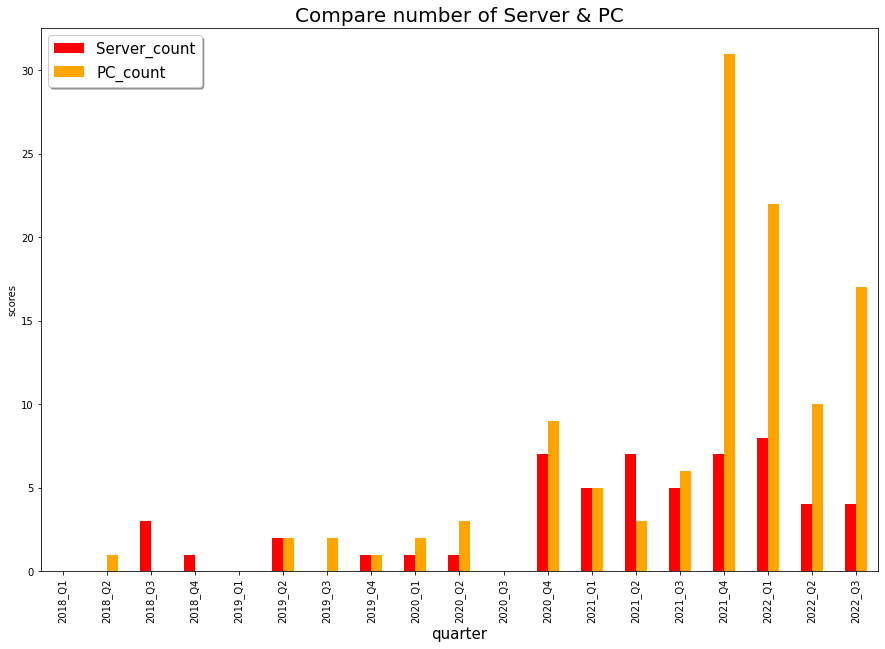

In [ ]:
COLORS = ["red", "orange", "green"]
TITLE = "Compare number of Server & PC"
plot_SR_PC.plot.bar(figsize=(15, 10), 
            color = COLORS).legend(fontsize = 15,
            loc = 'best', shadow = True)
plt.ylabel("scores")
plt.title(TITLE, fontsize = 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("quarter", fontsize=15)

#Vader SentimentAnalyzer (Emotional Analyze)

In [ ]:
# NLTK VADER for sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [ ]:
# Iterate through the headlines and get the polarity scores
scores = []
for texts in EC_df.text.values:
    text = " ".join(texts[0])
    scores.append(vader.polarity_scores(text)) 
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([EC_df[["title", "year"]], scores_df], axis=1)
scored_news.columns = ["title", "year", 'negative', 'neutral', 'positive', "compound"]


分類有正面、負面和中性極性分類。
其中，compound表示複雜程度，neu表示中性，neg表示負面情緒，pos表示正面情緒。


In [ ]:
TITLE = "Positive and negative sentiment for MU"
COLORS = ["red", "orange","green"]
sc = scored_news[scored_news["year"]>2015].set_index("title").sort_index()
plot_scores = sc.drop(['year', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
# plot_scores.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
plot_scores.plot.bar(stacked = True, figsize=(15, 10), color = COLORS).legend(fontsize = 15,
            loc = 'best', shadow = True)
plt.ylabel("scores")
plt.title(TITLE, fontsize = 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("year", fontsize=15)

In [ ]:
plot_scores_2 = plot_scores.copy()
plot_scores_2["p-n"] = plot_scores["positive"] - plot_scores["negative"]
plot_scores_2["p-n"].plot.bar(stacked = True, figsize=(15, 10)).legend(fontsize = 15,
            loc = 'best', shadow = True)
plt.ylabel("scores")
plt.title(TITLE, fontsize = 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("year", fontsize=15)

In [ ]:
plot_scores_2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
mean3 = scored_news.groupby("year").mean()

scores =['negative', 'neutral', 'positive']
for i in scores:
    mean3[i].plot.bar(figsize=(15,10))
    plt.title(i, fontsize = 20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("year", fontsize=15)
    plt.show()